## Template Analysis

In [2]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve as convolve
from scipy.stats import norm, skewnorm

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


/usr/local/lib/python3.8/dist-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
include_wls = True

In [4]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if zero_padding:
        ind = np.arange(n-1)
        a = np.insert(a, ind, np.zeros(n-1))
        a = np.roll(a, -int((n-1)/2))
    if const_padding:
        if n%2 != 1:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n-1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n/2)))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
        else:
            ind1 = np.arange((n-1)/2).astype(int)
            ind2 = -np.arange(1,(n+1)/2).astype(int)
            a = np.insert(a, ind1, np.ones(int((n-1)/2))*a[0])
            a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [5]:
#Returns binning needed to resolve a frequency.
def get_binning(sim, dt, frequency=80*u.Hz): 
    duration = sim.time[-1]-sim.time[0]
    samples = (duration/dt.to(u.s)).value
    return int((1/frequency*samples/duration).value) #binning needed to filter out sinals with f>f_lb_sasi

In [6]:
def get_template(frequency,n_period, binning):
    frequency, binning = frequency.value, binning.to(u.s).value
    duration = 1/frequency * n_period
    x = np.arange(0,duration+binning,binning)
    template = np.sin(frequency*x*2*np.pi)
    return x, template

In [7]:
# Binning of the moving average filter defined by the Nyquist frequency of the SASI modulation
# If the sampling was to be finer the binning could be done finer, however this comes at the expense of lower
# statistics. Therefore we keep the sampling rate at 1 ms.

def get_average_signal(sim, dt, distance, frequency=80*u.Hz):
    binning = get_binning(sim, dt, frequency)

    #detector_signal s0 is not drawn from distribution
    t, s0_i3 = sim.detector_signal(dt=dt, subdetector='i3')
    t, s0_dc = sim.detector_signal(dt=dt, subdetector='dc')
    t, s0_md = sim.detector_signal(dt=dt, subdetector='md')

    s0_ic86 = s0_i3 + s0_dc
    s0_gen2 = s0_i3 + s0_dc + s0_md
    t = t.to(u.ms)

    #averaged signal sa binning size defined by the Nyquist frequency of the SASI modulation and constant padding
    sa_ic86 = moving_average(s0_ic86, n=binning, const_padding=True)
    sa_gen2 = moving_average(s0_gen2, n=binning, const_padding=True)
    
    return sa_gen2, sa_ic86

In [8]:
dt = 0.1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 20*u.Msun,
             'direction': 1}
         }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.006*u.s, tmax=0.338*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = include_wls)
sim.run()

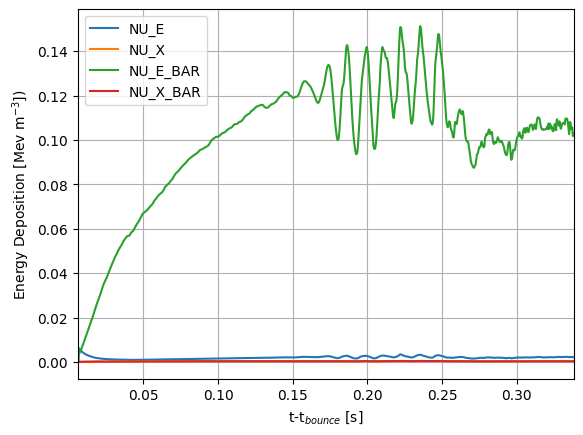

In [9]:
for flavor in sim.flavors:
    plt.plot(sim.time, sim.E_per_V[flavor], label=flavor.name)
plt.legend()
ax = plt.gca()
ax.set(xlabel=r't-t$_{bounce}$ [s]', ylabel='Energy Deposition [Mev m$^{-3}$])', xlim=(0.006, 0.338))
ax.grid()

In [10]:
dt = 1 * u.ms
sasi_wind = [140, 300] * u.ms
ana_wind = [160, 275] * u.ms

In [11]:
#average background given by the mean of the sensor distribution and scaled to the full detector
ba_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
ba_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)

In [12]:
def signal_processing(sim, dt, distance, trials, dist=skewnorm,
                     return_percentage=False,
                     return_correlation=False,
                     return_max_correlation=False,
                     return_bkg_fit=False,
                     return_significance=False):
         
    # scale simulation with distance
    sim.scale_result(distance=distance)
    
    sa_gen2, sa_ic86 = get_average_signal(sim, dt=dt, distance=distance)
    
    # time and signal realization for each detector component
    t, s_i3 = sim.detector_hits(dt=dt, subdetector='i3', size=trials)
    t, s_dc = sim.detector_hits(dt=dt, subdetector='dc', size=trials)
    t, s_md = sim.detector_hits(dt=dt, subdetector='md', size=trials)
    #t, s_ws = sim.detector_hits(dt=dt, subdetector='ws')
    t = t.to(u.ms)

    # random background realization
    b_i3 = sim.detector.i3_bg(dt=dt, size=s_i3.shape[1]*trials)
    b_dc = sim.detector.dc_bg(dt=dt, size=s_dc.shape[1]*trials)
    b_md = sim.detector.md_bg(dt=dt, size=s_md.shape[1]*trials)
    #b_ws = sim.detector.ws_bg(dt=dt, size=len(s_ws)*trials)
    
    # reshape background
    b_i3 = b_i3.reshape(trials,s_i3.shape[1])
    b_dc = b_dc.reshape(trials,s_dc.shape[1])
    b_md = b_md.reshape(trials,s_md.shape[1])
    
    # analysis window mask
    tmask = np.logical_and(t>=ana_wind[0], t<=ana_wind[1])
    
    # generate template of same shape in dimension 0 as data to convolve with
    t_template, template = get_template(frequency=80*u.Hz, n_period=8, binning=dt)
    template = np.tile(template, trials)
    template = template.reshape(trials,-1)
    
    ### SIGNAL TRIALS ###
    s_ic86 = s_i3 + s_dc
    s_gen2 = s_i3 + s_dc + s_md
    b_ic86 = b_i3 + b_dc
    b_gen2 = b_i3 + b_dc + b_md

    # combined signal S: signal + background
    S_ic86 = s_ic86 + b_ic86
    S_gen2 = s_gen2 + b_gen2

    # background subtraction Sb: signal + background - average background
    Sb_ic86 = S_ic86 - ba_ic86
    Sb_gen2 = S_gen2 - ba_gen2

    # percentage deviation Sp: (average signal + background - average background)/average signal
    Sp_ic86 = (Sb_ic86/sa_ic86)-1
    Sp_gen2 = (Sb_gen2/sa_gen2)-1
    
    # cross correlation in analysis window
    Sc_ic86 = -convolve(Sp_ic86[:,tmask], template, mode='same', axes=-1)
    Sc_gen2 = -convolve(Sp_gen2[:,tmask], template, mode='same', axes=-1)

    # maximum cross correlation
    Sm_ic86 = np.nanmax(Sc_ic86, axis=-1)
    Sm_gen2 = np.nanmax(Sc_gen2, axis=-1)
    
    ### BACKGROUND TRIALS ###
    # combined averaged signal B: average signal + background
    B_ic86 = sa_ic86 + b_ic86
    B_gen2 = sa_gen2 + b_gen2

    # background subtraction Bb: average signal + background - average background
    Bb_ic86 = B_ic86 - ba_ic86
    Bb_gen2 = B_gen2 - ba_gen2

    # deviation Bd: average signal + background - average background - average signal = background - average background
    Bd_ic86 = b_ic86 - ba_ic86
    Bd_gen2 = b_gen2 - ba_gen2

    # percentage deviation Bp: (average signal + background - average background)/average signal
    Bp_ic86 = (Bb_ic86/sa_ic86)-1
    Bp_gen2 = (Bb_gen2/sa_gen2)-1
    
    # cross correlation in analysis window
    Bc_ic86 = -convolve(Bp_ic86[:,tmask], template, mode='same', axes=-1)
    Bc_gen2 = -convolve(Bp_gen2[:,tmask], template, mode='same', axes=-1)

    # maximum cross correlation
    Bm_ic86 = np.nanmax(Bc_ic86, axis=-1)
    Bm_gen2 = np.nanmax(Bc_gen2, axis=-1)
    
    # background fit parameters
    Bfp_ic86 = dist.fit(Bm_ic86)
    Bfp_gen2 = dist.fit(Bm_gen2)

    # fitted background distribution
    Bf_ic86 = dist(*Bfp_ic86)
    Bf_gen2 = dist(*Bfp_gen2)
    
    ### SIGNIFICANCE ###
    p_gen2 = Bf_gen2.sf(np.median(Sm_gen2))
    p_ic86 = Bf_ic86.sf(np.median(Sm_ic86))
    
    # two-sided Z score corresponding to the respective p-value (1-alpha)
    #Z_ic86 = norm.ppf((1+p_ic86)/2)
    #Z_gen2 = norm.ppf((1+p_gen2)/2)
    Z_ic86 = norm.isf(p_ic86/2)
    Z_gen2 = norm.isf(p_gen2/2)
    
    if return_percentage:
        return t, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86
    
    if return_correlation:
        return t[tmask], Sc_gen2, Sc_ic86, Bc_gen2, Bc_ic86
    
    if return_max_correlation:
        return Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86
    
    if return_bkg_fit:
        return Bm_gen2, Bm_ic86, Bf_gen2, Bf_ic86
    
    if return_significance:
        return Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Z_gen2, Z_ic86, p_gen2, p_ic86

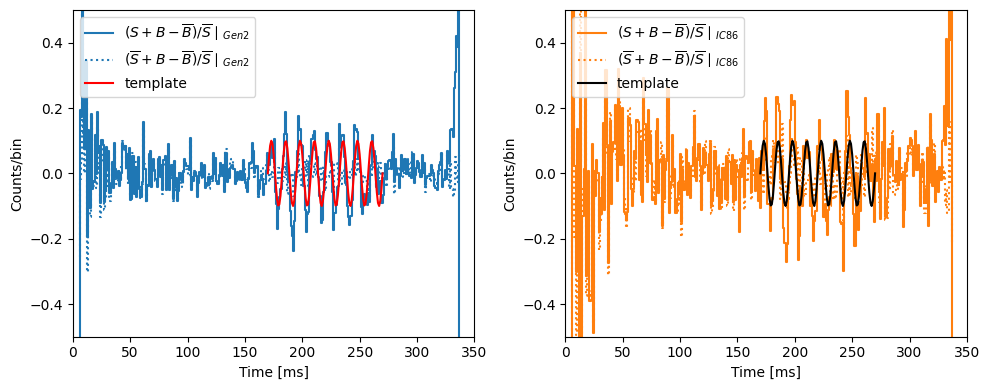

In [13]:
t, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10, return_percentage=True)

tt, ty = get_template(frequency=80*u.Hz, n_period=8, binning=dt)
tt = tt * u.s.to(u.ms)+170
ty /= 10
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,Sp_gen2[0], color = 'C0', ls = '-', label=r'$(S+B-\overline{B})/\overline{S}\mid_{Gen2}$')
ax[0].step(t,Bp_gen2[0], color = 'C0', ls = ':', label=r'$(\overline{S}+B-\overline{B})/\overline{S}\mid_{Gen2}$')
ax[0].plot(tt,ty, color='red', label='template')
ax[1].step(t,Sp_ic86[0], color = 'C1', ls = '-', label=r'$(S+B-\overline{B})/\overline{S}\mid_{IC86}$')
ax[1].step(t,Bp_ic86[0], color = 'C1', ls = ':', label=r'$(\overline{S}+B-\overline{B})/\overline{S}\mid_{IC86}$')
ax[1].plot(tt,ty, color='black', label='template')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Counts/bin')
ax[0].set_xlim(0,350)
ax[0].set_ylim(-0.5,0.5)
ax[0].legend(loc = 'upper left')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('Counts/bin')
ax[1].set_xlim(0,350)
ax[1].set_ylim(-0.5,0.5)
ax[1].legend(loc = 'upper left')
plt.tight_layout()

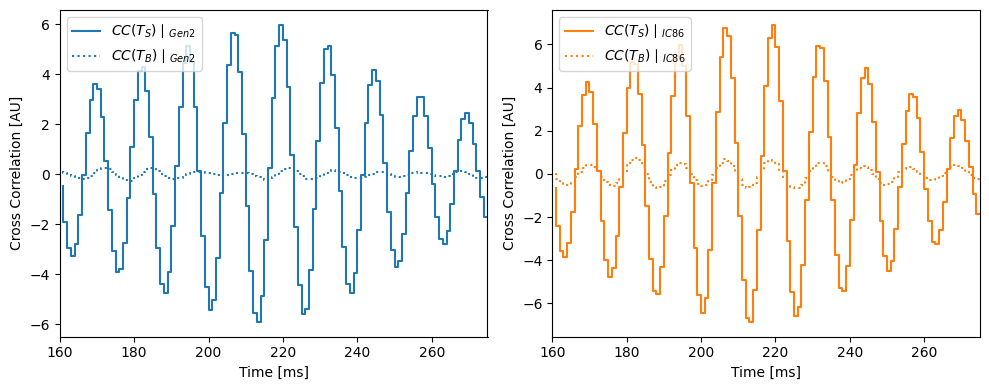

In [14]:
t, Sc_gen2, Sc_ic86, Bc_gen2, Bc_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=10, return_correlation=True)

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].step(t,Sc_gen2[0], color = 'C0', ls = '-', label=r'$CC(T_S)\mid_{Gen2}$')
ax[0].step(t,Bc_gen2[0], color = 'C0', ls = ':', label=r'$CC(T_B)\mid_{Gen2}$')
ax[1].step(t,Sc_ic86[0], color = 'C1', ls = '-', label=r'$CC(T_S)\mid_{IC86}$')
ax[1].step(t,Bc_ic86[0], color = 'C1', ls = ':', label=r'$CC(T_B)\mid_{IC86}$')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Cross Correlation [AU]')
ax[0].set_xlim(160,275)
#ax[0].set_ylim(-1,1)
ax[0].legend(loc = 'upper left')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('Cross Correlation [AU]')
ax[1].set_xlim(160,275)
#ax[1].set_ylim(-1,1)
ax[1].legend(loc = 'upper left')
plt.tight_layout()

In [15]:
Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86 = signal_processing(sim, dt=dt, distance=20*u.kpc, trials=100000, return_max_correlation=True)

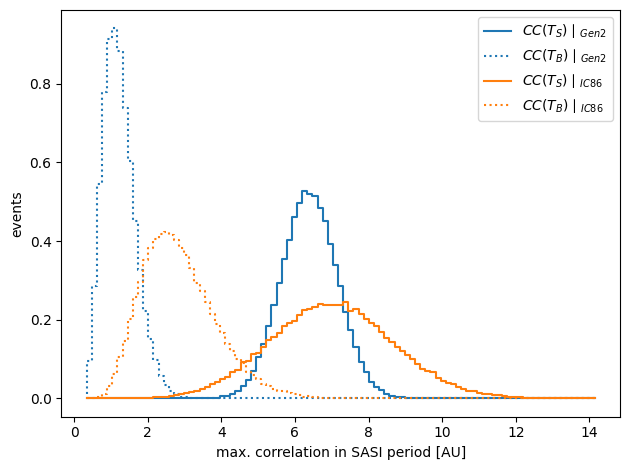

In [16]:
comb_data = np.hstack((Sm_ic86, Sm_gen2, Bm_ic86, Bm_gen2))
rmin, rmax, binning = np.min(comb_data), np.max(comb_data), 100

Sh_ic86, bins = np.histogram(Sm_ic86, bins = binning, density=True, range = [rmin,rmax])
Bh_ic86, bins = np.histogram(Bm_ic86, bins = binning, density=True, range = [rmin,rmax])
Sh_gen2, bins = np.histogram(Sm_gen2, bins = binning, density=True, range = [rmin,rmax])
Bh_gen2, bins = np.histogram(Bm_gen2, bins = binning, density=True, range = [rmin,rmax])
x = (bins[1:]+bins[:-1])/2

fig, ax = plt.subplots(1,1)
ax.step(x,Sh_gen2, color = 'C0', ls = '-', label=r'$CC(T_S)\mid_{Gen2}$')
ax.step(x,Bh_gen2, color = 'C0', ls = ':', label=r'$CC(T_B)\mid_{Gen2}$')
ax.step(x,Sh_ic86, color = 'C1', ls = '-', label=r'$CC(T_S)\mid_{IC86}$')
ax.step(x,Bh_ic86, color = 'C1', ls = ':', label=r'$CC(T_B)\mid_{IC86}$')
ax.set_xlabel('max. correlation in SASI period [AU]')
ax.set_ylabel('events')
ax.legend(loc = 'upper right')
plt.tight_layout()

In [17]:
Bm_gen2, Bm_ic86, Bf_gen2, Bf_ic86 = signal_processing(sim, dt=dt, distance=10*u.kpc, trials=100000, dist=skewnorm, return_bkg_fit=True)

In [18]:
Bpdf_gen2, bin_gen2 = np.histogram(Bm_gen2, bins = 'auto', density=True)#, range = [rmin,rmax])
Bpdf_ic86, bin_ic86 = np.histogram(Bm_ic86, bins = 'auto', density=True)#, range = [rmin,rmax])
x_gen2 = (bin_gen2[1:]+bin_gen2[:-1])/2
x_ic86 = (bin_ic86[1:]+bin_ic86[:-1])/2


Bcdf_gen2 = np.cumsum(Bpdf_gen2)/np.sum(Bpdf_gen2)
Bcdf_ic86 = np.cumsum(Bpdf_ic86)/np.sum(Bpdf_ic86)

significances = np.array([1,2,3,4,5])
qh_gen2, qh_ic86 = [], [] # quantiles from histogram
qf_gen2, qf_ic86 = [], [] # quantiles from fit

for sig in significances:
    cl = norm.cdf(sig)-norm.cdf(-sig)
    qf_gen2.append(Bf_gen2.ppf(cl))
    qf_ic86.append(Bf_ic86.ppf(cl))
    qh_gen2.append(np.quantile(Bm_gen2, cl))
    qh_ic86.append(np.quantile(Bm_ic86, cl))
Qh_gen2 = np.array(qh_gen2)
Qh_ic86 = np.array(qh_ic86)
Qf_gen2 = np.array(qf_gen2)
Qf_ic86 = np.array(qf_ic86)

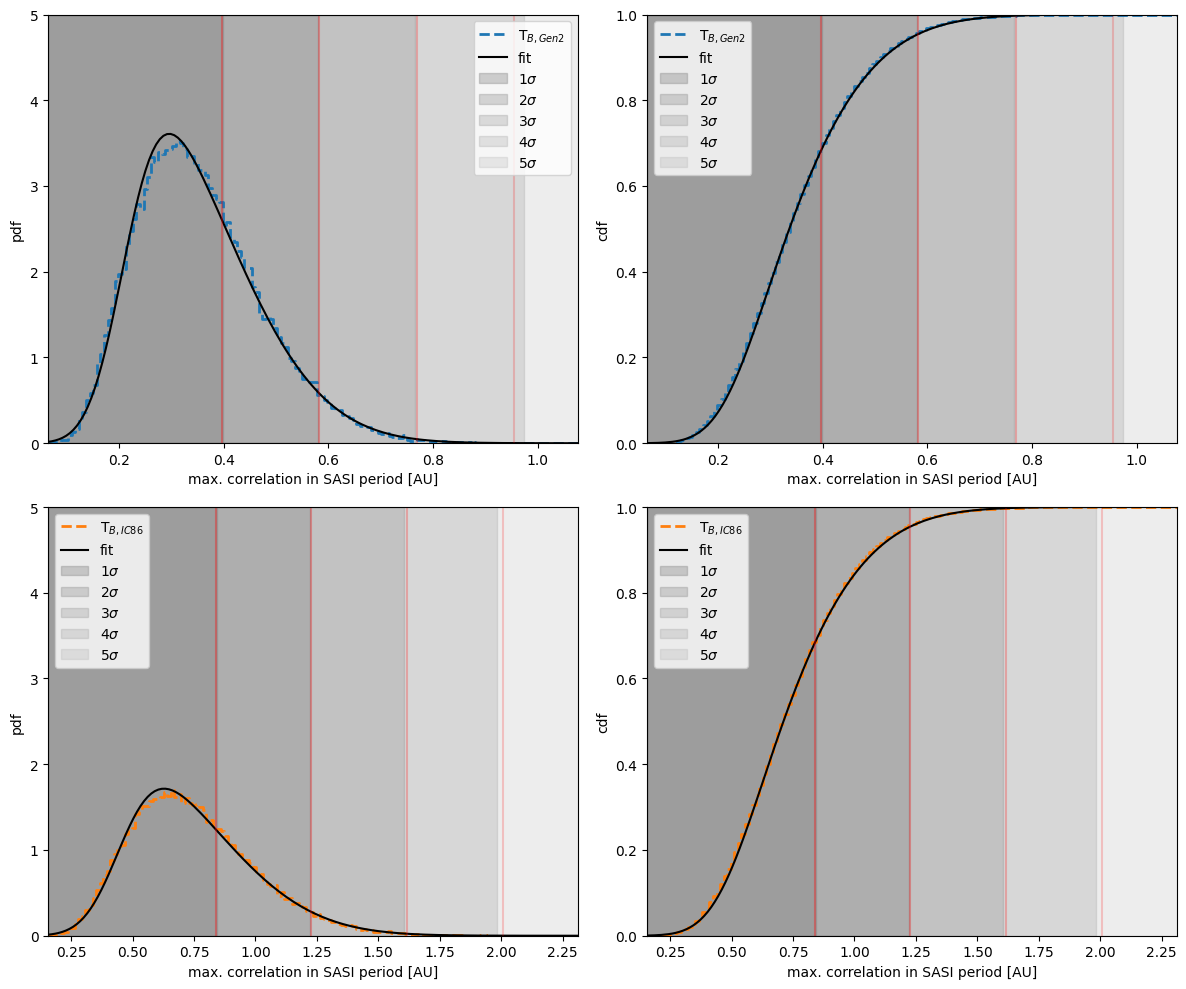

In [19]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax = ax.ravel()

ax[0].step(x_gen2, Bpdf_gen2, color = 'C0', ls = '--', label=r'T$_{B,Gen2}$', where='mid', lw = 2)
ax[0].plot(x_gen2, Bf_gen2.pdf(x_gen2), color = 'k', label = 'fit')
ax[1].step(x_gen2, Bcdf_gen2, color = 'C0', ls = '--', label=r'T$_{B,Gen2}$', where='mid', lw = 2)
ax[1].plot(x_gen2, Bf_gen2.cdf(x_gen2), color = 'k', label = 'fit')
ax[2].step(x_ic86, Bpdf_ic86, color = 'C1', ls = '--', label=r'T$_{B,IC86}$', where='mid', lw = 2)
ax[2].plot(x_ic86, Bf_ic86.pdf(x_ic86), color = 'k', label = 'fit')
ax[3].step(x_ic86, Bcdf_ic86, color = 'C1', ls = '--', label=r'T$_{B,IC86}$', where='mid', lw = 2)
ax[3].plot(x_ic86, Bf_ic86.cdf(x_ic86), color = 'k', label = 'fit')


for j in range(4):
    if j < 2:
        qh = Qh_gen2
        qf = Qf_gen2
        xmin = x_gen2.min()
        xmax = x_gen2.max()
    else:
        qh = Qh_ic86
        qf = Qf_ic86
        xmin = x_ic86.min()
        xmax = x_ic86.max()


    for i, qi in enumerate(qh):
        ax[j].axvspan(xmin, qh[i], label = r'{:d}$\sigma$'.format(significances[i]), alpha = (1-0.15*i)*0.35, color = 'grey')
        ax[j].axvline(qf[i],0,5, alpha = (1-0.15*i)*0.35, color = 'red')

    ax[j].set_xlabel('max. correlation in SASI period [AU]')
    ax[j].legend()
    ax[j].set_xlim(xmin,xmax)
    if j%2==0:
        ax[j].set_ylabel('pdf')
        ax[j].set_ylim(0,5)
        
    else:
        ax[j].set_ylabel('cdf')
        ax[j].set_ylim(0,1)

plt.tight_layout()
plt.savefig('./plots/template_analysis_bkg_trials_skewnorm.png')

In [43]:
distances = np.arange(1,41,1) * u.kpc
trials = 100000
Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Z_gen2, Z_ic86, P_gen2, P_ic86 = [], [], [], [], [], [], [], []
for d in distances:
    print('distance {:.0f}'.format(d))
    sm_gen2, sm_ic86, bm_gen2, bm_ic86, z_gen2, z_ic86, p_gen2, p_ic86 = signal_processing(sim, dt=dt, distance=d, 
                                                                         trials=trials, dist=skewnorm, 
                                                                         return_significance=True)    
       
    Sm_gen2.append([np.median(sm_gen2), np.quantile(sm_gen2, 0.14), np.quantile(sm_gen2, 0.86)])
    Sm_ic86.append([np.median(sm_ic86), np.quantile(sm_ic86, 0.14), np.quantile(sm_ic86, 0.86)])
    Bm_gen2.append([np.median(bm_gen2), np.quantile(bm_gen2, 0.14), np.quantile(bm_gen2, 0.86)])
    Bm_ic86.append([np.median(bm_ic86), np.quantile(bm_ic86, 0.14), np.quantile(bm_ic86, 0.86)])
    
    Z_gen2.append(z_gen2)
    Z_ic86.append(z_ic86)
    
    P_gen2.append(p_gen2)
    P_ic86.append(p_ic86)

Sm_gen2 = np.array(Sm_gen2)
Sm_ic86 = np.array(Sm_ic86)
Bm_gen2 = np.array(Bm_gen2)
Bm_ic86 = np.array(Bm_ic86)
Z_gen2 = np.array(Z_gen2)
Z_ic86 = np.array(Z_ic86)
P_gen2 = np.array(P_gen2)
P_ic86 = np.array(P_ic86)

distance 1 kpc
distance 2 kpc
distance 3 kpc
distance 4 kpc
distance 5 kpc
distance 6 kpc
distance 7 kpc
distance 8 kpc
distance 9 kpc
distance 10 kpc
distance 11 kpc
distance 12 kpc
distance 13 kpc
distance 14 kpc
distance 15 kpc
distance 16 kpc
distance 17 kpc
distance 18 kpc
distance 19 kpc
distance 20 kpc
distance 21 kpc
distance 22 kpc
distance 23 kpc
distance 24 kpc
distance 25 kpc
distance 26 kpc
distance 27 kpc
distance 28 kpc
distance 29 kpc
distance 30 kpc
distance 31 kpc
distance 32 kpc
distance 33 kpc
distance 34 kpc
distance 35 kpc
distance 36 kpc
distance 37 kpc
distance 38 kpc
distance 39 kpc
distance 40 kpc


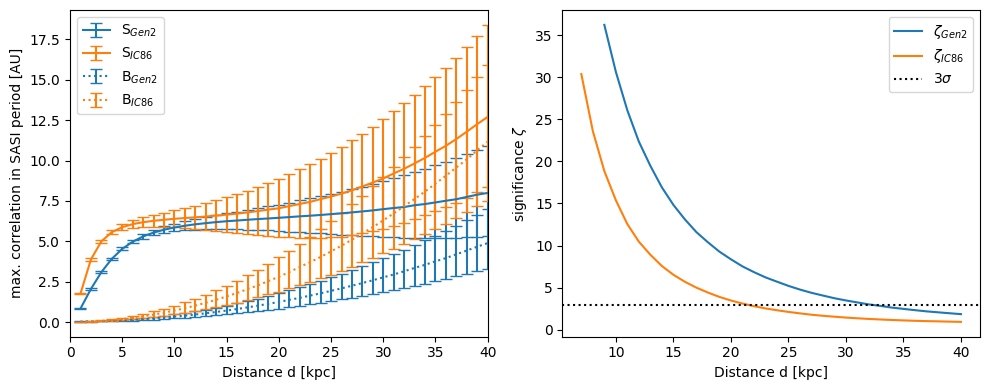

In [44]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

ax[0].errorbar(x=distances, y=Sm_gen2.T[0],yerr=(Sm_gen2.T[0]-Sm_gen2.T[1],Sm_gen2.T[2]-Sm_gen2.T[0]), capsize=4, color = 'C0', label=r'S$_{Gen2}$')
ax[0].errorbar(x=distances, y=Sm_ic86.T[0],yerr=(Sm_ic86.T[0]-Sm_ic86.T[1],Sm_ic86.T[2]-Sm_ic86.T[0]), capsize=4, color = 'C1', label=r'S$_{IC86}$')
ax[0].errorbar(x=distances, y=Bm_gen2.T[0],yerr=(Bm_gen2.T[0]-Bm_gen2.T[1],Bm_gen2.T[2]-Bm_gen2.T[0]), capsize=4, color = 'C0', ls = ':', label=r'B$_{Gen2}$')
ax[0].errorbar(x=distances, y=Bm_ic86.T[0],yerr=(Bm_ic86.T[0]-Bm_ic86.T[1],Bm_ic86.T[2]-Bm_ic86.T[0]), capsize=4, color = 'C1', ls = ':', label=r'B$_{IC86}$')
ax[0].set_xlabel('Distance d [kpc]')
ax[0].set_ylabel('max. correlation in SASI period [AU]')
ax[0].set_xlim((0,40))
ax[0].legend()

ax[1].plot(distances, Z_gen2, color = 'C0', label=r'$\zeta_{Gen2}$')
ax[1].plot(distances, Z_ic86, color = 'C1', label=r'$\zeta_{IC86}$')
ax[1].axhline(3, color='k', ls = ':', label = '3$\sigma$')
ax[1].set_xlabel('Distance d [kpc]')
ax[1].set_ylabel('significance $\zeta$')
#ax[1].set_xlim((0,20))
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].legend()
if include_wls:
    plt.savefig('./plots/results_template_IC86+Gen2+WLS_{:.0E}_trials.png'.format(trials))
else:
    plt.savefig('./plots/results_template_IC86+Gen2_{:.0E}_trials.png'.format(trials))

plt.tight_layout()

In [45]:
import pickle
data = [distances, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Z_gen2, Z_ic86]
if include_wls:
    file = open('./files/results_template_IC86+Gen2+WLS_{:.0E}_trials.pkl'.format(trials), 'wb')
else:
    file = open('./files/results_template_IC86+Gen2_{:.0E}_trials.pkl'.format(trials), 'wb')
pickle.dump(data,file)

In [46]:
file = open('./files/results_template_IC86+Gen2+WLS_{:.0E}_trials.pkl'.format(trials), 'rb')
pickle.load(file)

[<Quantity [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
            14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
            27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
            40.] kpc>,
 array([[ 0.83783804,  0.80468003,  0.87091997],
        [ 2.05131668,  2.01026373,  2.09281815],
        [ 3.09258007,  3.03984858,  3.14585178],
        [ 3.91844772,  3.84993318,  3.986683  ],
        [ 4.53235047,  4.44474118,  4.61938328],
        [ 4.97875174,  4.86846135,  5.0891203 ],
        [ 5.30170886,  5.16506765,  5.43993619],
        [ 5.54043497,  5.37347799,  5.70900816],
        [ 5.71850713,  5.51851052,  5.92075442],
        [ 5.85794288,  5.61939514,  6.09983615],
        [ 5.96524139,  5.68545121,  6.24676665],
        [ 6.05399289,  5.72771801,  6.38037775],
        [ 6.12514283,  5.74923578,  6.49886961],
        [ 6.19001773,  5.76256012,  6.62194827],
        [ 6.24499866,  5.76057398,  6.73030542],
        [ 6